<a href="https://colab.research.google.com/github/saaranshM/tfpractice/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_patter(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_patter(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 2357.9023
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 184.6995
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 97.5795
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 89.4347
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 87.7306
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 86.2372
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 83.9274
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 82.5503
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 80.4605
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 80.0003
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 77.3862
Epoch 12/100
31/31 [=

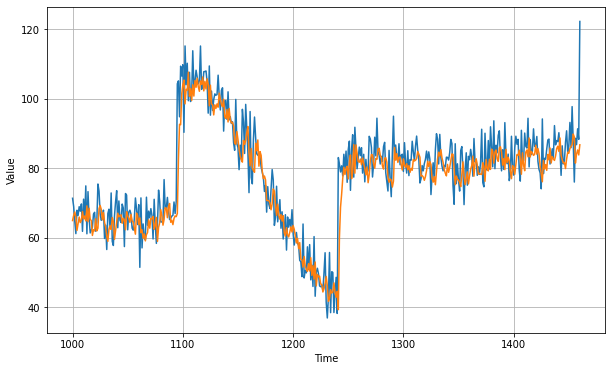

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0402975

In [19]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

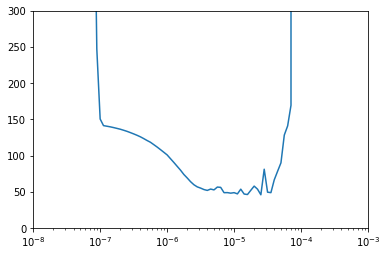

In [20]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [21]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

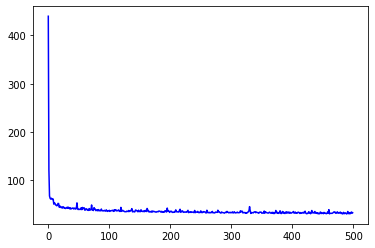

In [22]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[53.5588264465332, 52.012691497802734, 48.90327072143555, 48.56342315673828, 47.24522399902344, 48.61707305908203, 52.30122375488281, 51.680789947509766, 44.19935607910156, 46.93918991088867, 45.0715446472168, 43.51166915893555, 44.53030776977539, 42.453983306884766, 45.13106918334961, 44.95064926147461, 42.19383239746094, 42.8961296081543, 41.62818145751953, 42.35165786743164, 42.45163345336914, 44.47374725341797, 42.09635543823242, 44.30239486694336, 42.60602951049805, 40.967506408691406, 43.19155502319336, 40.49184036254883, 41.8173713684082, 41.721797943115234, 42.6786994934082, 42.34039306640625, 40.46491241455078, 42.35151672363281, 42.15926742553711, 40.32910919189453, 42.404144287109375, 53.293548583984375, 40.745216369628906, 39.455501556396484, 40.44322204589844, 40.001224517822266, 39.46142578125, 40.39930725097656, 43.30232620239258, 39.238773345947266, 43.78251266479492, 40.92137908935547, 42.3749885559082, 42.940879821777344, 37.99065399169922, 39.023963928222656, 41.1838

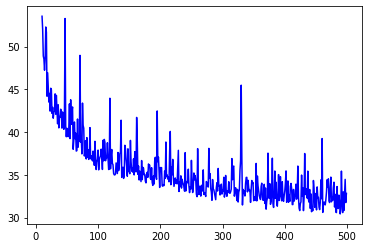

In [23]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

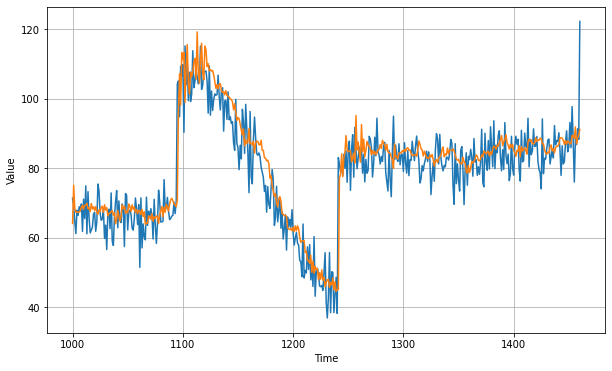

In [24]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0817013